# 1. Изучение данных

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

**Основная задача:** выявить определяющие успешность игры закономерности.

В данных присутствуют следующие столбцы: <br>
**Name** — название игры<br>
**Platform** — платформа<br>
**Year_of_Release** — год выпуска<br>
**Genre** — жанр игры<br>
**NA_sales** — продажи в Северной Америке (миллионы проданных копий)<br>
**EU_sales** — продажи в Европе (миллионы проданных копий)<br>
**JP_sales** — продажи в Японии (миллионы проданных копий)<br>
**Other_sales** — продажи в других странах (миллионы проданных копий)<br>
**Critic_Score** — оценка критиков (максимум 100)<br>
**User_Score** — оценка пользователей (максимум 10)<br>
**Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию <br>

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
df = pd.read_csv('games.csv')

In [3]:
report = df.isna().sum().to_frame()
report = report.rename(columns = {0: 'null_values'})
report['% of total'] = (report['null_values'] * 100/ df.shape[0]).round(1)
report.sort_values(by = 'null_values', ascending = False)
report.style.background_gradient(subset=['null_values'])

,null_values,% of total
Name,2,0.000000
Platform,0,0.000000
Year_of_Release,269,1.600000
Genre,2,0.000000
NA_sales,0,0.000000
EU_sales,0,0.000000
JP_sales,0,0.000000
Other_sales,0,0.000000
Critic_Score,8578,51.300000
User_Score,6701,40.100000


**Вывод:** Critic_Score, User_Score и Rating имеют большое количество пропусков. Далее буду рассматривать, что с ними делать.

# 2. Подготовка данных

Приведем названия столбцов к нижнему регистру 

In [4]:
df.columns = df.columns.str.lower()

В столбце **user_score**, кроме пропусков и значений содержится значения "tbd", которые стоит заменить на NaN, так как эта аббревиатура обозначает "Будет определено":

In [5]:
df.loc[df['user_score'] =='tbd','user_score'] = np.nan
df['user_score'] = df['user_score'].astype(float)

Запишем в столбец **total_sales** сумарные продажи во всех регионах

In [6]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales','other_sales']].sum(axis = 1)

Проверим наличие дубликатов:

In [7]:
df.duplicated().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
 11  total_sales      16715 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB


# 3. Исследовательский анализ данных

Распределение выпущенных игр по годам

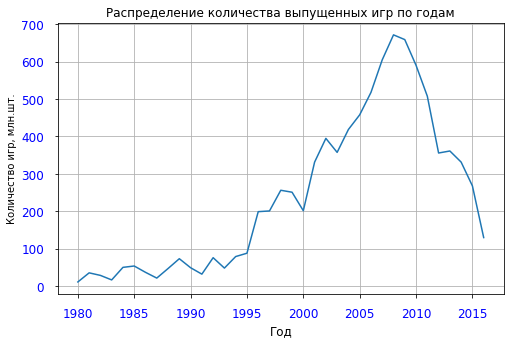

In [9]:
distrib_total_sales = df[df['year_of_release'] != 0].pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc='sum')
distrib_total_sales.columns = ['total_sales']
distrib_total_sales.plot(figsize = (8,5), grid =True)
plt.title('Распределение количества выпущенных игр по годам')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество игр, млн.шт.')
plt.legend().remove()
plt.tick_params(
    axis = 'both', # Применяем параметры к обеим осям
    pad = 10, # Расстояние между черточкой и ее подписью
    labelsize = 12, # Размер подписи
    labelcolor = 'b'
)

Максимальное значение:

In [10]:
distrib_total_sales[distrib_total_sales['total_sales'] == distrib_total_sales['total_sales'].max()]

,total_sales
year_of_release,
2008.0,671.5


**Вывод:** Наибольшее количество выпущенных игр пришлось на 2008 год. С 1995 по 2016 год пришлось наибольшая доля выпущенных игр.

Построим гистограмму продаж по платформам за весь период:

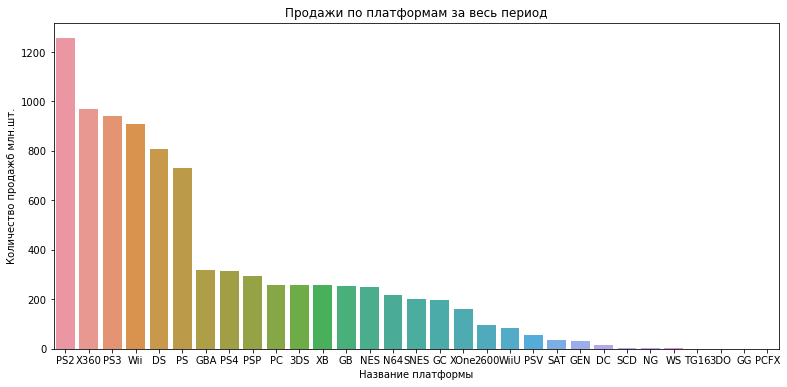

In [11]:
platform_on_sales = df.pivot_table(
    index='platform', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending=False)
plt.figure(figsize=(13,6))
sns.barplot(x = platform_on_sales.index,y = platform_on_sales['total_sales'])
plt.title("Продажи по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продажб млн.шт.");

Определим топ-10 платформ с наибольшим количеством выпущенных игр:

In [12]:
#Создадим список с названием топ-10 платформ
platform_top10 = df.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending = False)[:10].index
#Создадим сводную таблицу платформ, год выпуска и количества продаж
platform_pivot_table = df.pivot_table(index = ['platform', 'year_of_release'], values = 'total_sales', aggfunc = 'sum')
platform_pivot_table['years'] = platform_pivot_table.index
platform_pivot_table['years'] = platform_pivot_table['years'].apply(lambda row: row[1]).astype(int)

Построим гистограмму продаж топ-10 платформ за период с 2004 года: 

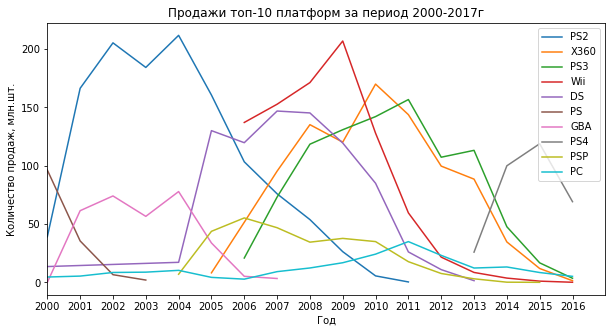

In [13]:
fig, ax = plt.subplots(figsize =(10,5))
for platform in platform_top10:
    platform_pivot_table.loc[platform].plot('years','total_sales', ax=ax)
ax.legend(platform_top10,prop = {'size':10})
ax.set_xlim([2000,2017])
ax.set_xticks(np.arange(2000,2017))
ax.set_title("Продажи топ-10 платформ за период 2000-2017г")
ax.set_xlabel("Год")
ax.set_ylabel("Количество продаж, млн.шт.");

**Вывод:** на графике видно, что в среднем платформы живут 10 лет. С 2004 года начинают активно появляться новые платформы: одна раз в 1-2 года.

Актуальным периодом по продажам считаю с 2013 по 2016 год.

Появление на рынке новой платформы говорит от том, что высокий рейтинг она будет занимать 2-4 года и топ продаж платформы ожидается на 2017 год.
После падения суммарных продаж с 2013 года появилась тенденция к росту продаж игр за счет их качества, а не количества.
Большинство студий разработчиков создают игры за 2-4 года, так что в 2017 попадут игры, разработка которых ведется с 2013 года.
Хорошие игры на рынке продаются в течении нескольких лет(2-4 года)

Сформируем новый DF

In [14]:
period = (2013, 2016)
df = df.query('@period[0] <= year_of_release <= @period[1]')

In [15]:
df['year_of_release'] = df['year_of_release'].astype(int)
actual_frame_pivot_table = df.pivot_table(index = ['year_of_release','platform'], 
                                                    values = 'total_sales',
                                                    aggfunc = 'sum')
#Пусть будет здесь, чтоб знать как вытаскивать индексы из мультииндексов
#new_df_pivot_table.index.get_level_values(1)

#Обработаем сводную таблицу для построения граффкрв
pivot_table_index = actual_frame_pivot_table.index
actual_frame_pivot_table["years"] = [year for year, platform in pivot_table_index]
actual_frame_pivot_table.index = [platform for year, platform in pivot_table_index]

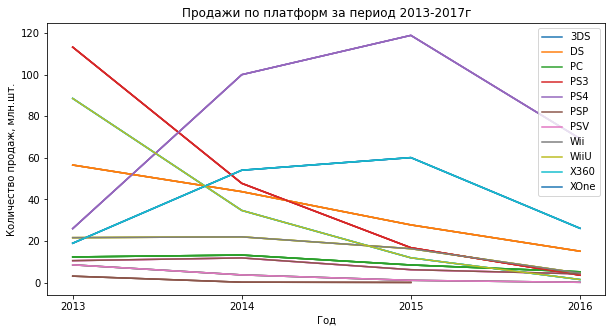

In [16]:
fig, ax = plt.subplots(figsize =(10,5))
for platform in actual_frame_pivot_table.index:
    ax.plot(actual_frame_pivot_table.loc[platform]['years'],
            actual_frame_pivot_table.loc[platform]['total_sales'])
ax.legend(actual_frame_pivot_table.index.unique(),prop = {'size':10})
ax.set_xticks(np.arange(2013,2017))
ax.set_title("Продажи по платформ за период 2013-2017г")
ax.set(xlabel='Год')
ax.set(ylabel='Количество продаж, млн.шт.');

**Вывод:** По графику видно, что все платформы имеют низходящий характер, кроме **PS4** и **XOne**. В 2015 году эти платформы имеют точку экстремума, и сменили направление своих продаж на убывание. Далее стоит ожидать появление новой платформы, которая станет хитом года. 

In [17]:
# КОД РЕВЬЮЕРА
df.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


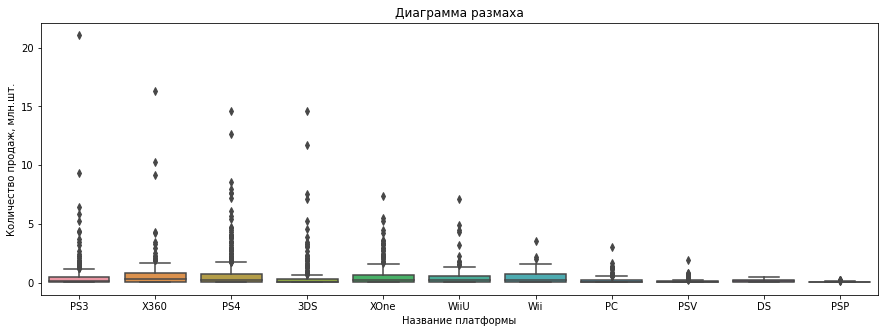

In [18]:
top_quantile = df['total_sales'].quantile(0.75)
low_quantile = df['total_sales'].quantile(0.25)
threshold = top_quantile + 2*low_quantile
fig, ax = plt.subplots(figsize =(15,5))
sns.boxplot(x = 'platform', 
            y = 'total_sales',
            #data = df.query('total_sales <= @threshold'),ax=ax)
            data = df,ax=ax)
plt.title("Диаграмма размаха")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж, млн.шт.");

**Вывод:** Избавевшись от выбросов, мы получили график. На нем видно, что медианные значения продаж на всех платформах приблизительно равны. Также стоит отметить, что большая часть данных каждой платформы находится выше медианного. 

Сформируем список топ-5 попюлярных платформ:

In [19]:
platform_top5 = df.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending = False)[:5].index

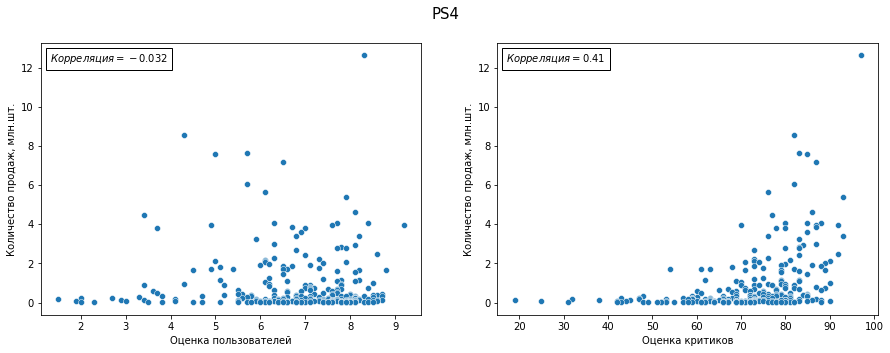

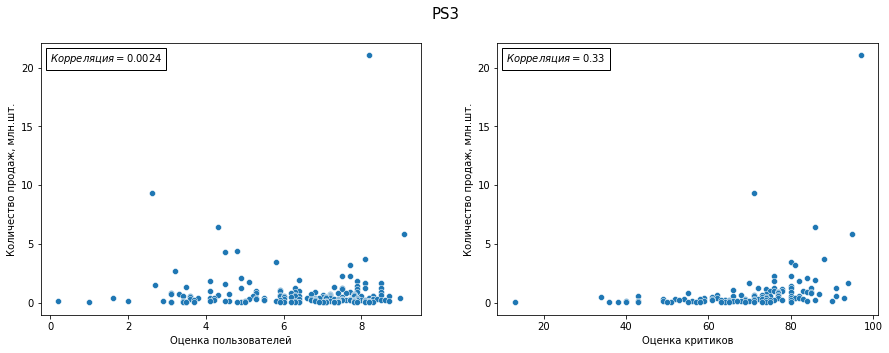

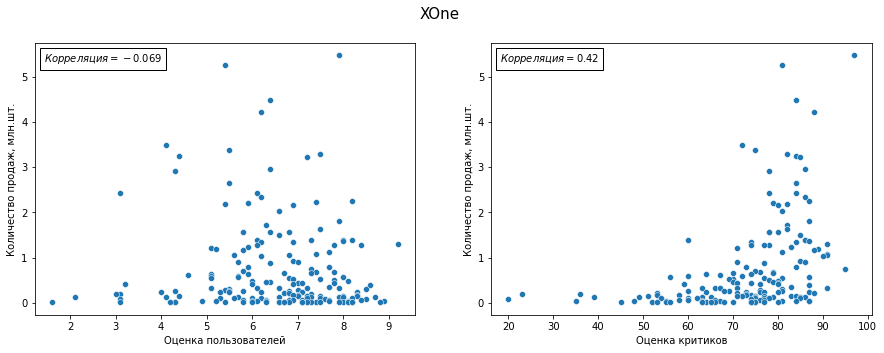

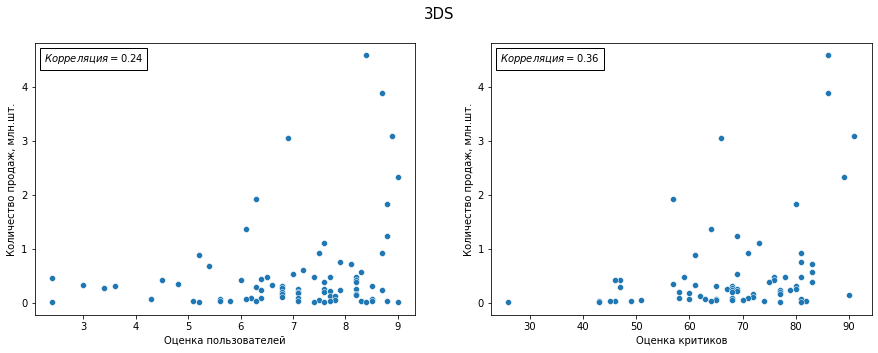

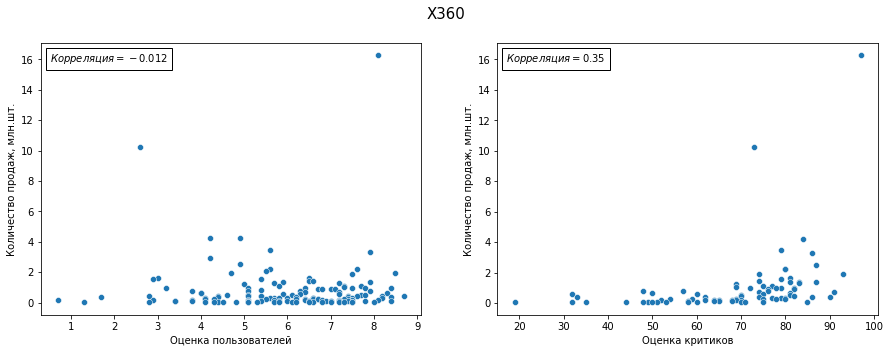

In [20]:
from matplotlib.offsetbox import AnchoredText
for platform in platform_top5:
    #Создадим данные по платформам для вычисления корреляции
    data_user_platform = df[df['platform'] == platform]['user_score']
    data_critic_platform = df[df['platform'] == platform]['critic_score']
    data_total_platform = df[df['platform'] == platform]['total_sales']
    #Вычислим корреляцию
    corr_user = data_user_platform.corr(data_total_platform)
    corr_critic = data_critic_platform.corr(data_total_platform).round(3)
    #Построение граффиков
    fig, ax = plt.subplots(1 ,2, figsize=(15,5))
    sns.scatterplot(x='user_score', y='total_sales', data=df[df['platform'] == platform], ax=ax[0])
    sns.scatterplot(x='critic_score', y='total_sales', data=df[df['platform'] == platform], ax=ax[1])
    fig.suptitle(platform, fontsize=15)
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж, млн.шт.')
    ax[1].set(ylabel='Количество продаж, млн.шт.')
    #Дополним графики якорным текстом
    user_score_corr = AnchoredText(r"$Корреляция = {:.2}$".format(corr_user), loc=2)
    critic_score_corr = AnchoredText(r"$Корреляция = {:.2}$".format(corr_critic), loc=2)
    ax[0].add_artist(user_score_corr)
    ax[1].add_artist(critic_score_corr)

**Вывод:** Построив граффики топ-5 попюлярных платформ и вычислив для каждых данных коэффициент корреляции, можно сказать следующее: оценка критиков сильнее влияет на количество продаж, чем оценка пользователей. 

Построем распределение по жанрам:

In [21]:
genre_pivot_table = df.pivot_table(index='genre', values='total_sales', aggfunc=['count', 'median', 'sum'])
genre_pivot_table.columns = ['count', 'median', 'sum']
genre_pivot_table = genre_pivot_table.sort_values('sum', ascending = False).reset_index()
genre_pivot_table

,genre,count,median,sum
0,Action,766,0.110,321.87
1,Shooter,187,0.450,232.98
2,Sports,214,0.240,150.65
3,Role-Playing,292,0.125,145.89
4,Misc,155,0.100,62.82
5,Platform,74,0.225,42.63
6,Racing,85,0.120,39.89
7,Fighting,80,0.125,35.31
8,Adventure,245,0.030,23.64
9,Simulation,62,0.100,21.76


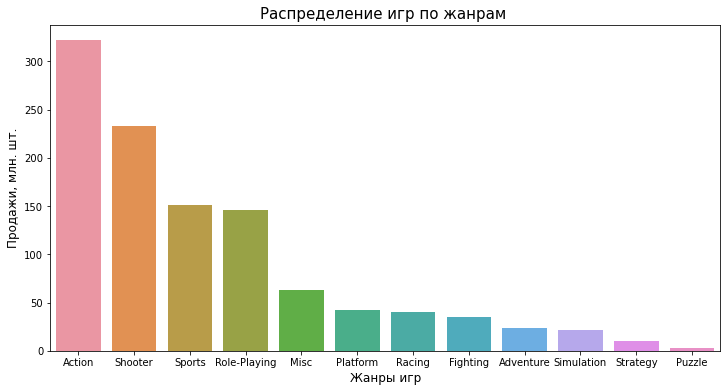

In [22]:
plt.figure(figsize=(12,6))
plt.title('Распределение игр по жанрам ',fontsize=15)
sns.barplot(data= genre_pivot_table, x='genre', y='sum')
plt.xlabel('Жанры игр',fontsize=12)
plt.ylabel('Продажи, млн. шт.',fontsize=12);

**Вывод:** Самый продаваемый жанр оказался 'Action' и низкопрадваемый 'Puzzle'. Также можно сказать, что большинство игр имеют жанр 'Action'.

#  4. Портрет пользователя каждого региона

Заполним пустые значения в столбце с рейтингом:

In [23]:
df['rating'] = df['rating'].fillna('None')

Составим функцию, которая определит в каждом регионе топ-5 платформ, жанров и рейтингов:

In [24]:
def total_table(row):
    columns_pivot = ['platform','genre','rating']
    for i in columns_pivot:
        total_pivot = df.pivot_table(index=i, values =row, aggfunc='sum')
        total_pivot.columns = ['sum']
        total_pivot['share'] = total_pivot['sum'] / sum(df[row])
        total_pivot = total_pivot.sort_values('sum', ascending = False).reset_index()[:5]
        print(total_pivot)
        print('\n\n')

Определим топ-5 попюлярных платформ, жанров и рейтингов на территории Северной Америки:

In [25]:
total_table('na_sales')

  platform     sum     share
0      PS4  108.74  0.248429
1     XOne   93.12  0.212744
2     X360   81.66  0.186562
3      PS3   63.50  0.145073
4      3DS   38.20  0.087272



          genre     sum     share
0        Action  126.05  0.287976
1       Shooter  109.74  0.250714
2        Sports   65.27  0.149117
3  Role-Playing   46.40  0.106006
4          Misc   27.49  0.062804



  rating     sum     share
0      M  165.21  0.377442
1   None   89.42  0.204291
2      E   79.05  0.180599
3   E10+   54.24  0.123918
4      T   49.79  0.113751





Определим топ-5 попюлярных платформ, жанров и рейтингов на территории Европы:

In [26]:
total_table('eu_sales')

  platform     sum     share
0      PS4  141.09  0.359712
1      PS3   67.81  0.172883
2     XOne   51.59  0.131530
3     X360   42.52  0.108406
4      3DS   30.96  0.078933



          genre     sum     share
0        Action  118.13  0.301175
1       Shooter   87.86  0.224001
2        Sports   60.52  0.154297
3  Role-Playing   36.97  0.094256
4        Racing   20.19  0.051475



  rating     sum     share
0      M  145.32  0.370497
1      E   83.36  0.212528
2   None   78.91  0.201183
3   E10+   42.69  0.108839
4      T   41.95  0.106953





Определим топ-5 попюлярных платформ, жанров и рейтингов на территории Японии:

In [27]:
total_table('jp_sales')

  platform    sum     share
0      3DS  67.81  0.481674
1      PS3  23.35  0.165862
2      PSV  18.59  0.132050
3      PS4  15.96  0.113368
4     WiiU  10.88  0.077284



          genre    sum     share
0  Role-Playing  51.04  0.362551
1        Action  40.49  0.287612
2          Misc   9.20  0.065350
3      Fighting   7.65  0.054340
4       Shooter   6.61  0.046953



  rating    sum     share
0   None  85.05  0.604134
1      T  20.59  0.146257
2      E  15.14  0.107544
3      M  14.11  0.100227
4   E10+   5.89  0.041838





**Вывод:** Список платформ на территории Северной Америки и Европый одинаковый: PS4, PS3, X360, 3DS, XOne. 
По рейтингам на территории Северной Америки и Европый одинаковый, как и в долевом соотношении.
Параметры на территория Японии сильно отличается от парасметров остальных исследуемых территорий. Например, самые популярный рейтинг в Японии является T «Подросткам 13—19 лет», в то время, как на территории Северной Америки и Европый - М «От 17 лет». Большая доля, примерно 20%, игр не имеет возрастной категории, а в Японии и вовсе большинство игр без кагерии, примерно 60%. 

# 5. Проверка гипотез

## Гипотеза 1

**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые** <br>
<br>
Нулевая гипотеза: одинаковые <br>
Альтернативная гипотеза: различаются

In [28]:
#Вычислим дисперсии
xone_var = st.variation(df.query('platform == "XOne"').dropna()['user_score'])
pc_var = st.variation(df.query('platform == "PC"').dropna()['user_score'])
print('Равны ли дисперсии двух совокупностей?',(xone_var * 0.05 < abs(xone_var - pc_var)))

Равны ли дисперсии двух совокупностей? True


In [29]:
alpha = 0.05
result_first = st.ttest_ind(df.query('platform == "XOne"').dropna()['user_score'],
                            df.query('platform == "PC"').dropna()['user_score'])

prob_first = result_first.pvalue
print('р-значение: ',prob_first)
if prob_first < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

р-значение:  0.17306926618147322
Не получилось отвергнуть нулевую гипотезу


In [30]:
print('Среднее значение платформы XOne:', round(df.query('platform == "XOne"').dropna()['user_score'].mean(), 3))
print('Среднее значение платформы PC:', round(df.query('platform == "PC"').dropna()['user_score'].mean(), 3))

Среднее значение платформы XOne: 6.538
Среднее значение платформы PC: 6.302


**Вывод:** Значение p-value равно 13%. Таким образом, не получилось опровергнуть нулевую гипотезу. То есть, с вероятностью в 13% можно получить различность рейтингов двух платформ.

## Гипотеза 2

**Средние пользовательские рейтинги жанров Action и Sports разные**<br>
<br>
Нулевая гипотеза: одинаковые <br>
Альтернативная гипотеза: различаются

In [31]:
#Вычислим дисперсии
action_var = st.variation(df.query('genre == "Action"').dropna()['user_score'])
sports_var = st.variation(df.query('genre == "Sports"').dropna()['user_score'])
print('Равны ли дисперсии двух совокупностей?',(((action_var * 0.05) < abs(action_var - sports_var))))

Равны ли дисперсии двух совокупностей? True


In [32]:
print('Среднее значение платформы XOne:', round(df.query('genre == "Action"').dropna()['user_score'].mean(), 3))
print('Среднее значение платформы PC:', round(df.query('genre == "Sports"').dropna()['user_score'].mean(), 3))

Среднее значение платформы XOne: 6.936
Среднее значение платформы PC: 5.665


In [33]:
result_second = st.ttest_ind(df.query('genre == "Action"').dropna()['user_score'],
                             df.query('genre == "Sports"').dropna()['user_score'])
prob_second = result_second.pvalue
print('р-значение: ',prob_second)
if prob_second < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

р-значение:  1.684099430689953e-16
Отвергаем нулевую гипотезу


**Вывод:** Значение p-value очень маленькое. Таким образом, получилось опровергнуть нулевую гипотезу. То есть, средние пользовательские рейтинги жанров Action и Sports отличаются.

## Общий вывод

Перед анализом данных, мы подготовили наши данные, привели к правильным данным столбцы и привели к правильным типам данных необходимые столбцы.<br>
<br>
Определили, что аббревиатура TBD значит to be determined, to be done. То есть данные были нарочно не заполнены. Поэтому заменили tbd на nan для проведения дальнейшего анализа.<br>
<br>
Также мы выявили, что средняя продолжительность жизни игровой приставки составляет порядка 10 лет. Самый пик продаж наступает примерно через 2-4 года после выпуска консоли<br>
<br>
Проведя анализ оценок пользователей и критиков. Мы выявили, что оценка критиков сильнее влияет на количество продаж, чем оценка пользователей.<br>
<br>
Так же определили, что самый популярный жанр за все время это Action.<br>
<br>
Выяснили что список платформ на территории Северной Америки и Европый одинаковый: PS4, PS3, X360, 3DS, XOne. 
По рейтингам на территории Северной Америки и Европый одинаковый, как и в долевом соотношении.
Параметры на территория Японии сильно отличается от парасметров остальных исследуемых территорий. Например, самые популярный рейтинг в Японии является T «Подросткам 13—19 лет», в то время, как на территории Северной Америки и Европый - М «От 17 лет». Большая доля, примерно 20%, игр не имеет возрастной категории, а в Японии и вовсе большинство игр без кагерии, примерно 60%. <br>
<br>
К потенциально прибыльным консолям стоит отнести PS4 и XOne.
<br>
**Популярные платформы:** <br>
Для европейского региона: PS3, PS4, XOne, X360, 3DS<br>
Для японского региона: 3DS, PS3, PSV, PS4, WiiU<br>
Для северо-американского региона: PS4, XOne, X360, PS3, 3DS<br>
<br>
**Популярные жанры:** <br>
Для европейского региона: Action, Shooter, Sports, Role-Playing, Racing<br>
Для японского региона: Role-Playing, Action, Misc, Fighting, Shooter<br>
Для северо-американского региона: Action, Shooter, Sports, Role-Playing, Misc<br>
<br>
**Популярные рейтинги:** <br>
Для европейского региона: M, E, E10+, T<br>
Для японского региона: T, E, M, E10+<br>
Для северо-американского региона: M, E, E10+, T<br>
<br>
**Исходя из всех данных предполагаем, что лучше всего продавать игры для таких приставок как PS4
Жанр необходимо выбирать Action и выбирать игры с рейтингом "от 17 и выше", тогда продажи будут значительно больше, чем если продавать другие игры.**